In [1]:
import pickle
import matplotlib.pylab as pl
%matplotlib inline
import numpy as np
import time
from utility import *

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


### Question 1
    Please refer to split_data.py and utility.py.

In [2]:
# pre-process data
training_X, training_Y, validation_X, validation_Y, test_X, test_Y, vocabulary = format_dataset(X=20)

### Question 2


In [3]:
def error(W, X, Y):
    # np.dot(X, W) * Y == 0 is not treated as error because there are feature vectors that only contains 0.
    return np.sum(np.dot(X, W) * Y < 0)
def perceptron_error(W, X, Y):
    N, D = X.shape
    return error(W, X, Y) / N
def perceptron_train(W, X, Y, learning_rate=1, logging_interval=1, maximum_n_iterations=None):
    N, D = X.shape
    total_n_errors = 0
    n_iterations = 0
    while True:
        t0 = time.time()
        predictions = np.dot(X, W)
        update_filter = predictions * Y < 0
        n_errors = np.sum(update_filter)
        if n_errors == 0: break
        else: total_n_errors += n_errors
        gradient = np.sum(update_filter * Y * X, axis=0).reshape((D, 1))
        W += learning_rate * gradient
        n_iterations += 1
        if maximum_n_iterations is not None and maximum_n_iterations < n_iterations: break
        if isinstance(logging_interval, int):
            if n_iterations % logging_interval == 0:
                print('iteration %d errors %d time %fs' % (n_iterations, n_errors, time.time() - t0))
    return W, total_n_errors, n_iterations

### Question 3
    Train perceptron.

In [4]:
D = len(vocabulary) # dimension of feature vector
W = np.random.normal(0, 1, (D, 1)) # initialize weights
N_TRAINING_SAMPLES = 4000
W, n_errors, n_iterations = perceptron_train(
    W,
    training_X[:N_TRAINING_SAMPLES],
    training_Y[:N_TRAINING_SAMPLES],
    logging_interval=50
)

iteration 50 errors 51 time 0.098136s
iteration 100 errors 11 time 0.098049s
iteration 150 errors 9 time 0.101265s
iteration 200 errors 3 time 0.101897s
iteration 250 errors 3 time 0.098574s


In [5]:
# total errors encountered
n_errors

15006

In [6]:
# number of iterations
n_iterations

256

In [7]:
# check whether there is no error on training set
perceptron_error(W, training_X, training_Y)

0.0

In [8]:
# test perceptron on validation set
validation_errors = perceptron_error(W, validation_X, validation_Y)
validation_errors

0.016

### Question 4
    Investigate most positive/negative words. It is reasonable that words related to advertisement, e.g. "dollarnumb", "click" receive very positive weights.

In [9]:
weights = W.tolist()
sorted_weights = sorted(weights)
N = 12
negative_N = tuple(vocabulary[weights.index(weight)] for weight in sorted_weights[:N])
positive_N = tuple(vocabulary[weights.index(weight)] for weight in sorted_weights[len(sorted_weights) - N:])
print('%d most negative words:' % N, *negative_N)
print('%d most positive words:' % N, *positive_N)

12 most negative words: wrote i but date user chang it on what thei set which
12 most positive words: free form sight below email dollarnumb we pleas your click remov our


### Question 5 & Question 6
    Investigate the influence of number of training samples on test accuracy and number of iteration.

In [10]:
# record number of iteration and validation error
n_update_table = {4000 : n_iterations}
validation_error_table = {4000 : validation_errors}
for N_TRAINING_SAMPLES in (100, 200, 400, 800, 2000):
    W = np.random.normal(0, 1, (D, 1))
    W, n_errors, n_iterations = perceptron_train(
        W,
        training_X[:N_TRAINING_SAMPLES],
        training_Y[:N_TRAINING_SAMPLES],
        logging_interval=None
    )
    n_update_table[N_TRAINING_SAMPLES] = n_iterations
    # use validation data to test perceptron
    validation_error_table[N_TRAINING_SAMPLES] = perceptron_error(W, validation_X, validation_Y)

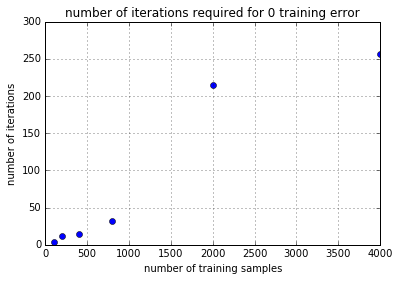

In [11]:
# plot number of iteration
pl.plot(list(n_update_table.keys()), list(n_update_table.values()), 'bo')
pl.xlabel('number of training samples')
pl.ylabel('number of iterations')
pl.title('number of iterations required for 0 training error')
pl.grid()

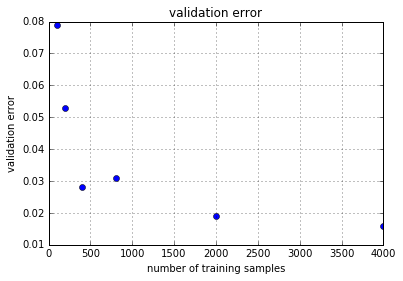

In [12]:
# plot validation error
pl.plot(list(validation_error_table.keys()), list(validation_error_table.values()), 'bo')
pl.xlabel('number of training samples')
pl.ylabel('validation error')
pl.title('validation error')
pl.grid()

### Question 7
    Control the maximum number of iterations and observe its influence.

In [13]:
W = np.random.normal(0, 1, (D, 1))
N_TRAINING_SAMPLES = 4000
MAXIMUM_n_iterations = 20
W, n_errors, n_iterations = perceptron_train(
    W,
    training_X[:N_TRAINING_SAMPLES],
    training_Y[:N_TRAINING_SAMPLES],
    maximum_n_iterations=MAXIMUM_n_iterations # set maximum number of iterations
)

iteration 1 errors 1888 time 0.114920s
iteration 2 errors 1251 time 0.117232s
iteration 3 errors 2664 time 0.109023s
iteration 4 errors 1251 time 0.102234s
iteration 5 errors 845 time 0.101758s
iteration 6 errors 590 time 0.101067s
iteration 7 errors 477 time 0.099957s
iteration 8 errors 245 time 0.100957s
iteration 9 errors 177 time 0.098763s
iteration 10 errors 131 time 0.100522s
iteration 11 errors 123 time 0.098916s
iteration 12 errors 118 time 0.098978s
iteration 13 errors 113 time 0.100606s
iteration 14 errors 114 time 0.098815s
iteration 15 errors 111 time 0.098837s
iteration 16 errors 106 time 0.101076s
iteration 17 errors 99 time 0.098991s
iteration 18 errors 96 time 0.098690s
iteration 19 errors 92 time 0.101197s
iteration 20 errors 89 time 0.098969s


In [14]:
# validation error
perceptron_error(W, validation_X, validation_Y)

0.019

### Question 8
    Search the hyperparameter space of X.

In [15]:
validation_error_table = {}
optimal_validation_error = 1
for X in (30, 40, 50, 60, 80, 100, 120, 160, 200):
    training_X, training_Y, validation_X, validation_Y, test_X, test_Y, vocabulary = format_dataset(X)
    W = np.random.normal(0, 1, (len(vocabulary), 1))
    W, n_errors, n_updates = perceptron_train(W, training_X, training_Y, logging_interval=None)
    validation_error = perceptron_error(W, validation_X, validation_Y)
    validation_error_table[X] = validation_error
    if validation_error < optimal_validation_error:
        optimal_validation_error = validation_error
        optimal_W = W

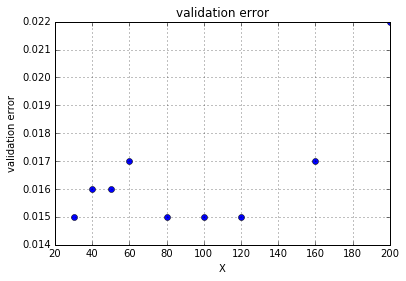

In [16]:
# plot validation error
pl.plot(list(validation_error_table.keys()), list(validation_error_table.values()), 'bo')
pl.xlabel('X')
pl.ylabel('validation error')
pl.title('validation error')
pl.grid()

In [17]:
# test optimal perceptron
perceptron_error(W, test_X, test_Y)

0.021999999999999999

### Question 9
    Provided X equaling 1200, the data is not linearly separable.

In [18]:
# generate data
training_X, training_Y, validation_X, validation_Y, test_X, test_Y, vocabulary = format_dataset(X=1200)

In [19]:
# number of features
len(vocabulary)

53

In [20]:
# count the number of identical data points that are labelled differently
positive_set = set(tuple(point) for point in training_X[training_Y.flatten() == 1].tolist())
negative_set = set(tuple(point) for point in training_X[training_Y.flatten() == -1].tolist())
len(positive_set & negative_set)

9

### Question 10
    The purpose of training set is to enable model to learn from data. Validation set is used to optimize hyperparameters involved in model while not touching test data. Test set is used to evaluate the performance of a model when it encounters data that it never encountered previously.